In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import QFTGate  
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library.basis_change import QFT


In [2]:
def multi_x_gate(num_targets, num_ctrl):
    qc = QuantumCircuit(num_targets, name="X")
    for i in range(num_targets):
        qc.x(i)
    return qc.to_gate().control(num_ctrl)

In [3]:
def qft_adder(x, y, c):
    adder = QuantumCircuit(x,y,c, name = "Add")
    num_bits = len(x)

    # QFT on y
    adder.append(QFT(num_bits+1, do_swaps=False).to_gate(), list(y) + [c[0]])
    
    for i in range(num_bits):
        for j in range(i + 1):
            angle = np.pi / (2 ** (i - j))
            adder.cp(angle, x[j], y[i])

    for j in range(num_bits):
        angle = np.pi / (2 ** (num_bits - j))
        adder.cp(angle, x[j], c[0])

    # Inverse QFT on y
    adder.append(QFT(num_bits+1, do_swaps=False, inverse=True).to_gate(), list(y) + [c[0]])


    adder = adder.to_gate()
    return adder

In [4]:
def s2c(x,y,c):
    num_bits = len(x)

    qc = QuantumCircuit(y, c, name="S2C")

    sum_reg = list(y) + [c[0]]  # q = y0 ... yn,c


    for i in range(1, num_bits + 1):
        controls = sum_reg[:i]                 
        targets = sum_reg[i:]                  
        if targets:
            gate = multi_x_gate(num_targets=len(targets), num_ctrl=len(controls))
            qc.append(gate, controls + targets)

        if i != num_bits:
            qc.x(sum_reg[i-1])
        elif num_bits > 1:
            qc.x(sum_reg[0:num_bits - 1])

    qc = qc.to_gate()

    return qc



In [5]:
def smalls2c(y):
    num_bits = len(y)
    qc = QuantumCircuit(y, name="S2C")

    sum_reg = list(y)  # q = y0 ... yn


    for i in range(1, num_bits + 1):
        controls = sum_reg[:i]                 
        targets = sum_reg[i:]                  
        if targets:
            gate = multi_x_gate(num_targets=len(targets), num_ctrl=len(controls))
            qc.append(gate, controls + targets)
        if i != num_bits:
            qc.x(sum_reg[i-1])
        elif num_bits > 1:
            qc.x(sum_reg[0:num_bits - 1])

    qc = qc.to_gate().control()

    return qc

In [6]:
def ctrls2c(x,y,c):


    qc = smalls2c(y)

    qc.append(qc, list(c) + list(y))

    return qc

In [7]:
def subtract(x,y,c):
    qc = QuantumCircuit(x,y,c, name = "Sub")
    num_bits = len(x)
    s2c_gate = s2c(x,y,c)
    qc.append(s2c_gate, list(y) + list(c))

    adder = qft_adder(x,y,c)
    qc.append(adder,list(x) + list(y) + list(c))
    ctrls2c = smalls2c(y)
    qc.append(ctrls2c, list(c)+list(y))

    qc = qc.to_gate()
    return qc

C:\Users\sunfr\AppData\Local\Temp\ipykernel_37668\1019000970.py:6: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  adder.append(QFT(num_bits+1, do_swaps=False).to_gate(), list(y) + [c[0]])
C:\Users\sunfr\AppData\Local\Temp\ipykernel_37668\1019000970.py:18: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  adder.append(QFT(num_bits+1, do_swaps=False, inverse=True).to_gate(), list(y) + [c[0]])


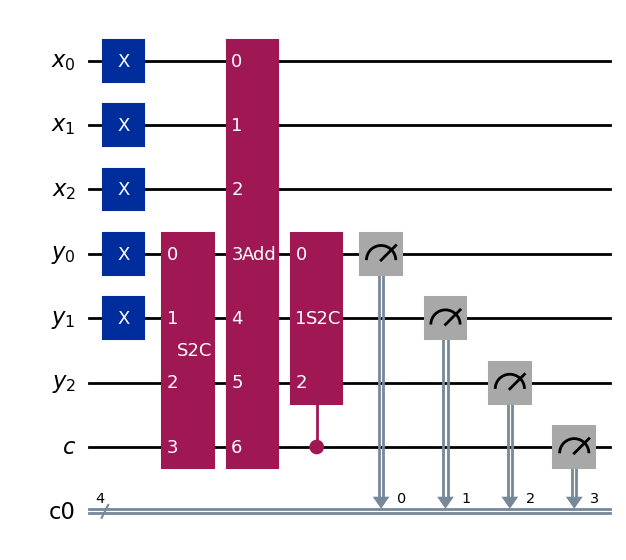

In [8]:
num_bits = 3
x_val = 7
y_val = 3
num_total_qubits = 2 * num_bits + 1

x = QuantumRegister(num_bits, name='x')
y = QuantumRegister(num_bits, name='y')
c = QuantumRegister(1, name='c')
c2 = QuantumRegister(2, name='c2')
cr = ClassicalRegister(num_bits+1)
qc = QuantumCircuit(x, y, c, cr)

for i in range(num_bits):
    if (x_val >> i) & 1:
        qc.x(x[i])
    if (y_val >> i) & 1:
        qc.x(y[i])

s2c_gate = s2c(x,y,c)
qc.append(s2c_gate, list(y) + list(c))
adder = qft_adder(x,y,c)
qc.append(adder,list(x) + list(y) + list(c))
ctrls2c = smalls2c(y)
qc.append(ctrls2c, list(c)+list(y))



qc.measure(list(y) + list(c), range(num_bits+1))

qc.draw('mpl')

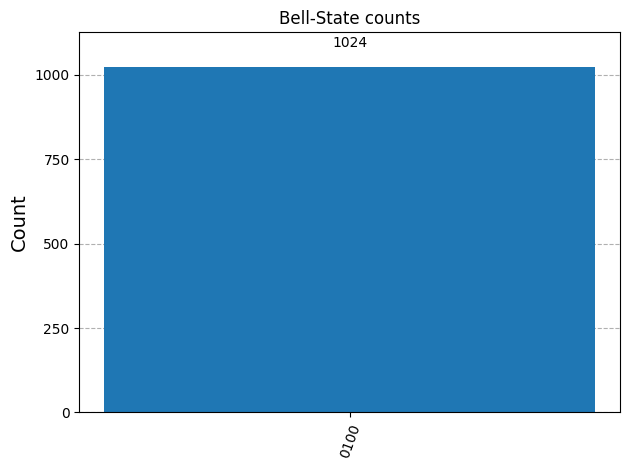

In [9]:
simulator = AerSimulator()
circ = transpile(qc, simulator)

result = simulator.run(circ).result()
counts = result.get_counts(circ)
plot_histogram(counts, title='Bell-State counts')